In [1]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import cython
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [38]:
train_labels = pd.read_csv('train_labels.csv', index_col='building_id')
train_values = pd.read_csv('train_values.csv', index_col='building_id')
merged = train_labels.merge(train_values, right_index=True, left_index=True)

# Feature Engenierg

En el analisis exploratorio vimos que:
    - age: las edificaciones que recibieron daños bajos tienden a ser mas nuevas que las otras
    - superestructure: a los de barro en general les fue mal
    - pisos: separar en grupos de 1,2,3 o mas.
    - apartir de cierta edad terminaron mas hechas bosta. Las de 995 tienen la misma distribucion que el resto
    - cimientos: clasificar en i,r y resto

Opciones:
 - los geo_level_id son iguales si coinciden en:
         - los 3 niveles
         - algun nivel
         -  de afuera para adetro (si coinciden en 1 un punto, si coinciden en el 1 y el 2 2..)
  - numero de pisos: si 1 esta mas cerca de 2 que de 3 o estan todos a la misma distancia. Tendria sentido que el 2 vaya con los de + de 3 (de cualquiera de las 2 formas). Se podria pasar a 2 los que eran mas de 3
    

In [39]:
cols_irrelvantes = ["land_surface_condition", "area_percentage",
                    "position", "count_families"]
train_values_short = train_values.drop(columns=cols_irrelvantes)


categoricas = ['foundation_type', 'roof_type', 'ground_floor_type', "other_floor_type",
              "plan_configuration", "legal_ownership_status"]

# Usamos mean target encoding que despues va a servir para las distancias
for col in categoricas:
    train_values_short[col] = merged[[col, 'damage_grade']].groupby(col).transform('mean')


train_values_short['geo_id'] = merged[['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
    'damage_grade']].groupby(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'])\
    .transform('mean')

train_values_short.drop(columns=['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'],
                       inplace=True)

# Ordeno las columnas en el orden en el que voy a ir asignando los factores
# (orden de importancia a priori)
train_values_short = train_values_short[['has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
        'geo_id', 
       'count_floors_pre_eq', 'age', 'height_percentage', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type',
       'plan_configuration',
       'legal_ownership_status', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']]

Hacemos lo mismo para el geo_level_id dado que en el analisis explorotorio vimos que no parecian estar ordenados (ej: el 17 no estaba al lado del 18) por lo que no tendria sentido restarlos. En cambio, se puede suponer una tendencia a que en el caso de regiones que hayan tenido en promedio daños similares, sus edificaciones se vieron afectadas de forma similar por encontrarse alli.

# KNN

### Distancias

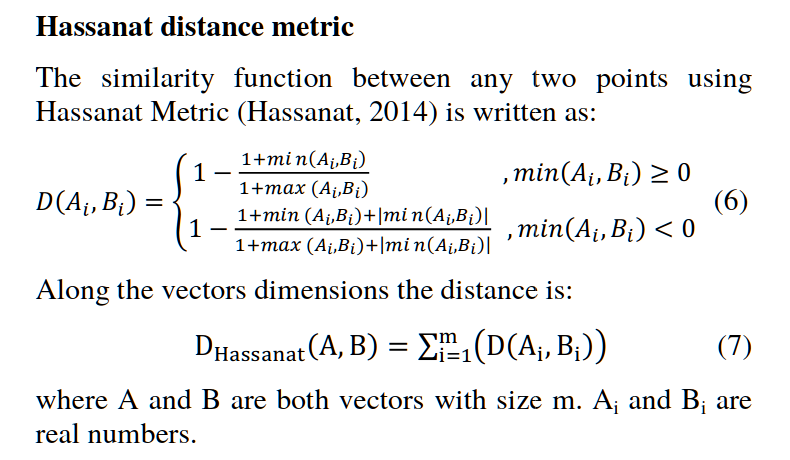

In [40]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [41]:
%%cython
def hassanat(double[:] x, double[:] y):
    cdef int n = x.shape[0]
    cdef double res = 0
    cdef double d, minimo, maximo
    
    for i in range(n):
        minimo = min(x[i],y[i])
        maximo = max(x[i],y[i])

        if (minimo >=0):
            d =  1 - ( (1+minimo)/(1+maximo) )
        else:
            d =  1 - ( (1+minimo+abs(minimo))/(1+maximo+abs(minimo)) )
        res += d
    
    return res

### Modelo

#### Optimizacion bayesiana

In [18]:
x_train, x_test, y_train, y_test = train_test_split(train_values_short,
                                train_labels, test_size=0.02) 

In [42]:
%%cython
def hassanat1(double[:] x, double[:] y, double[:] factores):
    cdef int n = x.shape[0]
    cdef double res = 0
    cdef double d, minimo, maximo

    for i in range(n):
        minimo = min(x[i],y[i])
        maximo = max(x[i],y[i])
        if (minimo >=0):
            d =  1 - ( (1+minimo)/(1+maximo) )
        else:
            d =  1 - ( (1+minimo+abs(minimo))/(1+maximo+abs(minimo)) )
        res += d * factores[i]
    
    return res

In [20]:
def funcion_a_optimizar(k, factor_superestructuras):
    k = round(k)
    factores = np.concatenate((np.repeat(factor_superestructuras,11),np.repeat(1,21)))
    knn = KNeighborsClassifier(weights="distance",n_neighbors=k,
                  metric=hassanat1, metric_params={'factores':factores})
    knn.fit(x_train, y_train.values.ravel())
    prediction = knn.predict(x_test)
    return f1_score(y_test, prediction, average='micro')

In [21]:
limites = {'k':(3,15), 'factor_superestructuras':(5,10)}

optimizer = BayesianOptimization(
    f=funcion_a_optimizar,
    pbounds=limites,
    random_state=1,
)

In [22]:
optimizer.maximize(
    init_points=2,
    n_iter=20,
)

|   iter    |  target   | factor... |     k     |
-------------------------------------------------
|  1        |  0.7209   |  7.085    |  11.64    |
|  2        |  0.7174   |  5.001    |  6.628    |
|  3        |  0.7209   |  7.218    |  11.5     |
|  4        |  0.7236   |  10.0     |  15.0     |
|  5        |  0.7228   |  10.0     |  13.17    |
|  6        |  0.7236   |  8.508    |  15.0     |
|  7        |  0.7232   |  5.0      |  15.0     |
|  8        |  0.7029   |  10.0     |  3.0      |
|  9        |  0.7236   |  6.73     |  14.98    |
|  10       |  0.7203   |  9.24     |  14.39    |
|  11       |  0.7194   |  10.0     |  9.775    |
|  12       |  0.7199   |  5.0      |  10.18    |
|  13       |  0.7027   |  5.0      |  3.0      |
|  14       |  0.7222   |  5.0      |  13.03    |


KeyboardInterrupt: 

# Feature engeniering II

Dado que la funcion de distancia es muy lenta, voy a hacer pruebas para ver si codificando las columnas booleanas con mean encoding anda mas rapido

In [8]:
x_train, x_test, y_train, y_test = train_test_split(train_values_short,
                                train_labels, test_size=0.0005)

In [130]:
# Lo corro como estaba antes
factores = np.concatenate((np.repeat(10,11),np.repeat(1,21))).astype('double')
knn = KNeighborsClassifier(weights="distance",n_neighbors=15,
metric=hassanat1, metric_params={'factores':factores})
knn.fit(x_train, y_train.values.ravel())
start = time.time()
prediction = knn.predict(x_test)
stop = time.time()
print(stop-start)
print(f1_score(y_test, prediction, average='micro'))

71.24405860900879
0.7938931297709924


In [46]:
train_values_short.drop(columns='has_secondary_use', inplace=True)
# Tiro esta columna porque solamente indica lo mismo que otras

In [43]:
secondary_uses =  ['has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']

superestructures = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other']



train_values_short['secondary_use'] = merged.groupby(secondary_uses).damage_grade.transform('mean')
train_values_short.drop(columns=secondary_uses, inplace=True)

In [44]:
train_values_short['superestructure'] = merged.groupby(superestructures).damage_grade.transform('mean')
train_values_short.drop(columns=superestructures, inplace=True)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(train_values_short,
                                train_labels, test_size=0.0005)

In [12]:
factores = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10]).astype('double')
knn = KNeighborsClassifier(weights="distance",n_neighbors=15,
metric=hassanat1, metric_params={'factores':factores})
knn.fit(x_train, y_train.values.ravel())
start = time.time()
prediction = knn.predict(x_test)
stop = time.time()
print(stop-start)
print(f1_score(y_test, prediction, average='micro'))

29.418328046798706
0.7480916030534351


Como tardo la mitad y aparente la efectividad no cambio tanto voy a seguir con este

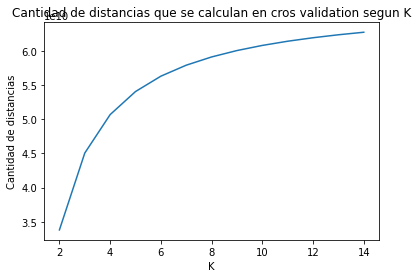

In [170]:
cant_distancias = []
for k in range(2,15):
    tamanio_folds = 260000/k
    cant_distancias.append(tamanio_folds * tamanio_folds * (k-1) *k)
    
plt.plot(range(2,15), cant_distancias)
plt.title('Cantidad de distancias que se calculan en cros validation segun K')
plt.xlabel('K')
plt.ylabel('Cantidad de distancias')
plt.show()

Calculo que usar cros validation con K=2 tardaria 8 horas, por lo que sigue siendo bastante

# Optimizacion bayesiana II

In [52]:
x_train, x_test, y_train, y_test = train_test_split(train_values_short,
                                train_labels, test_size=0.025)

In [53]:
# Tengo que adaptar al nuevo df
def funcion_a_optimizar1(k, factor_superestructuras):
    k = round(k)
    factores = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10]).astype('double')
    knn = KNeighborsClassifier(weights="distance",n_neighbors=k,
                  metric=hassanat1, metric_params={'factores':factores})
    knn.fit(x_train, y_train.values.ravel())
    prediction = knn.predict(x_test)
    return f1_score(y_test, prediction, average='micro')

In [60]:
limites = {'k':(15,30), 'factor_superestructuras':(6.5,15)}

optimizer = BayesianOptimization(
    f=funcion_a_optimizar1,
    pbounds=limites,
    random_state=4,
    bounds_transformer=SequentialDomainReductionTransformer()
)
load_logs(optimizer,logs=["./logs_anteriores.json"])
logger = JSONLogger(path="./logs_nuevos.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [63]:
optimizer.maximize(
    init_points=0,
    n_iter=1,
)

In [64]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.7203806015960712, 'params': {'factor_superestructuras': 10.205956668207032, 'k': 15.38889347741837}}
Iteration 1: 
	{'target': 0.7234499693063229, 'params': {'factor_superestructuras': 13.579324460707818, 'k': 21.069165674304887}}
Iteration 2: 
	{'target': 0.72268262737876, 'params': {'factor_superestructuras': 13.218268150316664, 'k': 21.814679516700252}}
Iteration 3: 
	{'target': 0.7213014119091468, 'params': {'factor_superestructuras': 15.0, 'k': 19.653942464209067}}
Iteration 4: 
	{'target': 0.7213014119091468, 'params': {'factor_superestructuras': 12.703433958548061, 'k': 20.46682835003278}}
Iteration 5: 
	{'target': 0.7234499693063229, 'params': {'factor_superestructuras': 13.996920645654875, 'k': 21.462493794118366}}
Iteration 6: 
	{'target': 0.72268262737876, 'params': {'factor_superestructuras': 14.944031358225788, 'k': 22.385708329657927}}
Iteration 7: 
	{'target': 0.7225291589932473, 'params': {'factor_superestructuras': 13.857708814026948, 'k': 2

In [68]:
optimizer.max

{'target': 0.7294352363413137,
 'params': {'factor_superestructuras': 14.318416163761984,
  'k': 20.827980819591588}}

# Submission I

In [126]:
test_values = pd.read_csv('test_values.csv', index_col='building_id')

In [127]:
# Hago los cambios que en las columnas que habia hecho antes pero para el set de test

def mean_encoding(df, cols, nombre_col):
    means = merged.groupby(cols).damage_grade.mean().reset_index()

    means [nombre_col] = means.apply(lambda x: '-'.join(x[cols].values.astype(int).astype(str)), axis="columns")   
    dic = means.set_index(nombre_col)['damage_grade'].to_dict()

    df_short = df
    df_short[nombre_col] = df_short.apply(lambda x: '-'.join(x[cols].values.astype(int).astype(str)), axis="columns")
    df_short.replace({nombre_col:dic},inplace=True)
    
    return (df_short)

In [128]:
secondary_uses =  ['has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']

superestructures = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other']

geo_levels = ["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"]

In [129]:
test_values_short = mean_encoding(test_values, geo_levels, 'geo_id')

In [137]:
# Hay combinaciones de geo_level_id que no estaban en el merged
# para esos casos voy a usar el promedio de los primeros 2 geo_level_id
unfound = test_values_short[test_values_short.geo_id.str.contains("-",na=False)].index.to_list()

for i in unfound:
    geo_id1 = test_values.loc[i].geo_level_1_id
    geo_id2 = test_values.loc[i].geo_level_2_id
    mean = merged.loc[(merged['geo_level_1_id']==geo_id1)&
               (merged['geo_level_2_id']==geo_id2),'damage_grade'].mean()

    test_values_short.loc[i,'geo_id'] = mean
    
test_values_short.drop(columns=geo_levels, inplace=True)

In [138]:
test_values_short = mean_encoding(test_values_short, superestructures, 'superestructure')
test_values_short.drop(columns=superestructures, inplace=True)

In [139]:
test_values_short = mean_encoding(test_values_short, secondary_uses, 'secondary_use')
test_values_short.drop(columns=secondary_uses, inplace=True)

In [140]:
categoricas = ['foundation_type', 'roof_type', 'ground_floor_type', "other_floor_type",
              "plan_configuration", "legal_ownership_status"]

# Aca reemplazo por el promedio en el set de datos
for col in categoricas:
    dic = (merged[[col, 'damage_grade']].groupby(col).mean().to_dict()['damage_grade'])
    test_values_short.replace({col:dic},inplace=True)

In [142]:
# Ordenos las columnas como en otro
test_values_short = test_values_short[['geo_id', 'count_floors_pre_eq', 'age', 'height_percentage',
       'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
       'plan_configuration', 'legal_ownership_status', 'secondary_use',
       'superestructure']]

In [144]:
# Guardo el archivo para despues no tener que repteri todo esto
test_values_short.to_csv('test_values_short.csv', index=True)

In [24]:
test_values_short=pd.read_csv('test_values_short.csv')

In [31]:
# Lo divido en partes porque esto va a tardar bastante
test1 = test_values_short.iloc[:34400].set_index('building_id')
test2 = test_values_short.iloc[34400:60200].set_index('building_id')
test3 = test_values_short.iloc[60200:].set_index('building_id')

In [59]:
start = time.time()
factores = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 14.318416163761984]).astype('double')
knn = KNeighborsClassifier(weights="distance",n_neighbors=21,
    metric=hassanat1, metric_params={'factores':factores})
knn.fit(train_values_short, train_labels.values.ravel())
prediction1 = knn.predict(test1)
end = time.time()
print(round(end-start))

ValueError: could not convert string to float: '15-1105-8616'